In [1]:
# Import all neccesary python libraries for analysis.
import pymc as pm
import pandas as pd
import pyreadr
import nutpie
import arviz as az

# Overview
Meta analysis is a critical statistical method within any analysts toolkit a “analysis of analyses” (Glass 1976) if you will. What Glass is pointing out is that unit of analysis in meta-analysis are the results of analyses. This analysis here is an example of the a simple application of meta-analysis where the analysis of analyses is specifcally directed at the analysis of effect size estimates from the group of analyses.

 The following meta analysis is a Bayesian hierchial model generated using the PyMC PPL framework and the associated Rust based nutpie Hamiltonian monte Carlo sampler. The basis for this analysis is from Harrer et al. (2021) where analysis was conducted using R and the brms package.

 ## The data

 The data balysed here has been downloaded from [dmetar github](https://github.com/MathiasHarrer/dmetar/blob/master/data/ThirdWave.rda) and is called the Thirdwave data set. This dataset is a collection of studies of third wave psychotherapies on percieved stress of college students. This simplify things here as this dataset comes with pre-calculated measures of effects size. This effect size here is specifcally *Hedges' g* (Henceforth just methioned as effect size estimates) and what is also critical within this analysis is the associated standard error of the  *Hedges' g* estimates.

In [40]:
# Import rda file into OrderedDict.
keys = pyreadr.read_r("data/ThirdWave.rda")

# Extract from OrderedDict the pandas dataframe.
df = keys["ThirdWave"]

# Convert author values to ctegroical codes
df['Author'] = pd.Categorical(df['Author'])
author_id = df['Author'].cat.codes

# Extract the data for analysis
seTE = df["seTE"]
TE = df["TE"]

In [47]:
# Generate pymc Bayesian Hierachial model
with pm.Model() as model:
    
    SMD = pm.Normal("SMD", mu = 0, sigma = 1)
    tau = pm.HalfCauchy("tau", beta=.5)
    # Random intercepts
    theta = pm.Normal('alpha', mu=0, sigma = tau, shape=len(df["Author"].unique()))
    y = pm.Normal("y", mu = SMD + theta[author_id], sigma = seTE, observed=TE)
   

In [48]:
# Compile nutpie pymc model.
compiled_model = nutpie.compile_pymc_model(model)
trace = nutpie.sample(compiled_model)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.62,15
,1300,0,0.58,7
,1300,0,0.59,7
,1300,0,0.55,15
,1300,0,0.60,7
,1300,0,0.58,7


In [43]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [49]:
# Get the results of the model MCMC samples.
az.summary(trace, var_names=["tau", "SMD"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.297,0.101,0.104,0.471,0.003,0.002,951.0,574.0,1.01
SMD,0.571,0.095,0.399,0.757,0.002,0.002,1706.0,2168.0,1.00


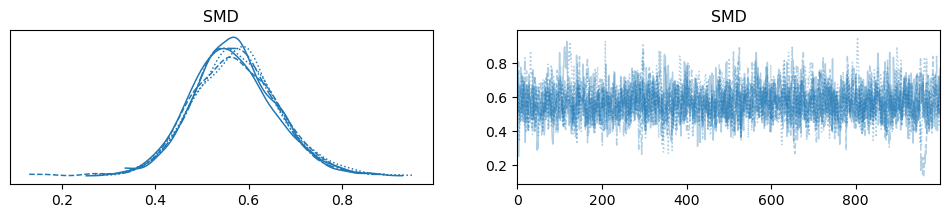

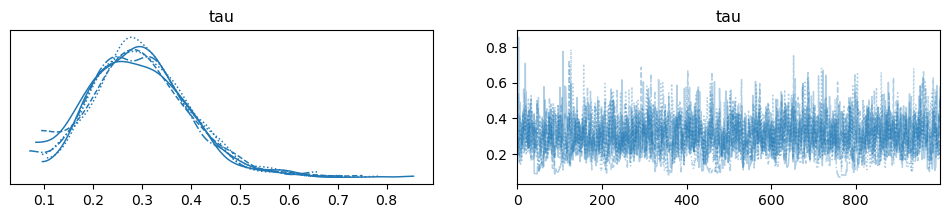

In [51]:
az.plot_trace(trace, var_names="SMD");
az.plot_trace(trace, var_names="tau");

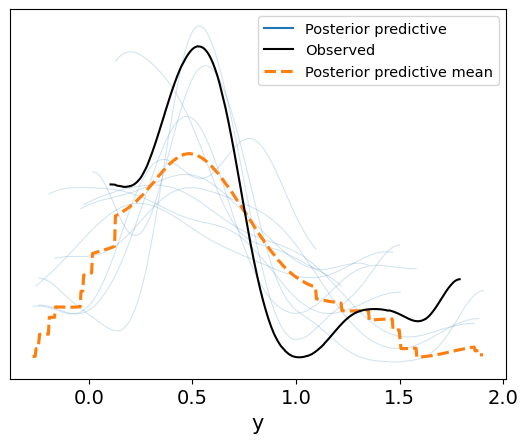

In [30]:
az.plot_ppc(trace, num_pp_samples=10);

# References
Glass, Gene V. 1976. “Primary, Secondary, and Meta-Analysis of Research.” Educational Researcher 5 (10): 3–8.

Harrer, M., Cuijpers, P., Furukawa, T.A., & Ebert, D.D. (2021). Doing Meta-Analysis with R: A Hands-On Guide. Boca Raton, FL and London: Chapmann & Hall/CRC Press. ISBN 978-0-367-61007-4.

Röver, Christian. 2017. “Bayesian Random-Effects Meta-Analysis Using the ‘Bayesmeta‘ r Package.” ArXiv Preprint 1711.08683.